# Init

In [1]:
%matplotlib inline
import pandas
import numpy
import logging
import pickle
from scipy import stats
from sklearn.neighbors import KDTree
from sklearn.neighbors import DistanceMetric
from sklearn.mixture import GMM

# Get test and training sets

In [2]:
test = pandas.read_csv('test.csv')
train = pandas.read_csv('train.csv')
print('Test size', test.shape)
print('Train size', train.shape)

('Test size', (8607230, 5))
('Train size', (29118021, 6))


In [52]:
train.shape

(28370006, 8)

In [3]:
train.describe()

,row_id,x,y,accuracy,time,place_id
count,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07
mean,1.455901e+07,4.999770e+00,5.001814e+00,8.284912e+01,4.170104e+05,5.493787e+09
std,8.405649e+06,2.857601e+00,2.887505e+00,1.147518e+02,2.311761e+05,2.611088e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000016e+09
25%,7.279505e+06,2.534700e+00,2.496700e+00,2.700000e+01,2.030570e+05,3.222911e+09
50%,1.455901e+07,5.009100e+00,4.988300e+00,6.200000e+01,4.339220e+05,5.518573e+09
75%,2.183852e+07,7.461400e+00,7.510300e+00,7.500000e+01,6.204910e+05,7.764307e+09
max,2.911802e+07,1.000000e+01,1.000000e+01,1.033000e+03,7.862390e+05,9.999932e+09


# Downsample training set

In [48]:
'''day_in_minutes = 60 * 24
train_days = 30
train_subset_time = day_in_minutes * train_days

print('Train subset interval:', train_subset_time / day_in_minutes, 'days')

train = train[train.time <= train_subset_time].copy()
train.reset_index(inplace=True, drop=True)
train.describe()'''

('Train subset interval:', 30, 'days')


,row_id,x,y,accuracy,time,place_id
count,1.288113e+06,1.288113e+06,1.288113e+06,1.288113e+06,1.288113e+06,1.288113e+06
mean,1.456215e+07,5.008968e+00,5.019589e+00,6.625677e+01,2.224284e+04,5.513268e+09
std,8.408575e+06,2.875458e+00,2.888410e+00,8.623728e+01,1.246822e+04,2.607118e+09
min,1.000000e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000016e+09
25%,7.281653e+06,2.513900e+00,2.525100e+00,1.400000e+01,1.155700e+04,3.248488e+09
50%,1.456127e+07,5.027600e+00,5.003000e+00,6.000000e+01,2.266800e+04,5.543382e+09
75%,2.184664e+07,7.509700e+00,7.544400e+00,7.100000e+01,3.315400e+04,7.770358e+09
max,2.911801e+07,1.000000e+01,1.000000e+01,1.016000e+03,4.320000e+04,9.999863e+09


# Add time features

In [4]:
timestamps = pandas.to_datetime(train.time * 60e9)
train['weekhour'] = timestamps.dt.hour * timestamps.dt.dayofweek
train['day'] = timestamps.dt.day
#train['dayofyear'] = timestamps.dt.dayofyear

if 'test' in locals():
    timestamps = pandas.to_datetime(test.time * 60e9)
    test['weekhour'] = timestamps.dt.hour * timestamps.dt.dayofweek
    #test['dayofyear'] = timestamps.dt.dayofyear
    test['day'] = timestamps.dt.day

test.head()

,row_id,x,y,accuracy,time,weekhour,day
0,0,0.1675,1.3608,107,930883,50,9
1,1,7.3909,2.5301,35,893017,0,13
2,2,8.0978,2.3473,62,976933,20,10
3,3,0.9990,1.0591,62,907285,3,23
4,4,0.6670,9.7254,40,914399,0,27


# Place model - spatial

In [8]:
# remove outliers
train_location = train_full[['place_id', 'x', 'y']]
byplace = train_location.groupby(['place_id'])

outliers = byplace.transform(lambda x: abs(x-x.mean()) > 3*x.std())
rows_before = train.shape[0]
train = train[~(outliers.x | outliers.y)]
train.reset_index(inplace=True, drop=True)
print('Outliers found:', rows_before - train.shape[0])

('Outliers found:', 748015)


In [10]:
byplace = train.groupby(['place_id'])

places = byplace.mean()
places['checkins'] = byplace.row_id.size()
places.reset_index(inplace=True)
places['place_index'] = places.index
places.drop('row_id', axis=1, inplace=True)
places.drop('time', axis=1, inplace=True)
places.head()

,place_id,x,y,accuracy,weekhour,day,checkins,place_index
0,1000015801,2.678153,5.550288,81.333333,53.373333,15.333333,75,0
1,1000017288,7.336637,4.346527,61.263158,41.463158,13.642105,95,1
2,1000025138,0.985063,5.570256,71.920721,35.544144,16.221622,555,2
3,1000052096,2.808096,5.833847,76.454158,16.512793,15.478678,938,3
4,1000063498,3.873112,7.552142,152.385965,38.000000,14.421053,57,4


In [33]:
places.to_csv('models/places.csv', index=False)
#print(train_full.shape, train.shape)

# Place model - spatial - Gaussian Mixture Model

In [44]:
def get_gmm(place, n_components=3):
    
    if place.shape[0] <= 10 * n_components:
        return None
    
    gmm = GMM(n_components, covariance_type='full', random_state=0)
    gmm.fit(place[['x', 'y']])
    return gmm

gmms = [get_gmm(group) for name, group in byplace]

In [51]:
with open('models/gmms.pickle', 'wb') as handle:
  pickle.dump(gmms, handle)
#print(len(gmms), len(byplace))
#gmms[0].score([[2.6, 5.5]])

array([ 2.12207803])

# Place model - time

In [11]:
byplace_hour = train_full.groupby(['place_id', 'weekhour'], as_index=False)
places_hour = byplace_hour.mean()
places_hour['checkins_weekhour'] = byplace_hour.size().values
places_hour.drop('row_id', axis=1, inplace=True)
places_hour.drop('accuracy', axis=1, inplace=True)
places_hour.drop('x', axis=1, inplace=True)
places_hour.drop('y', axis=1, inplace=True)
places_hour.drop('time', axis=1, inplace=True)
places_hour.drop('day', axis=1, inplace=True)

places_hour = pandas.merge(places_hour, places[['place_id', 'checkins']], on='place_id', sort=False)
places_hour['time_likelihood'] = places_hour['checkins_weekhour'] / places_hour['checkins']

places_hour.head()

,place_id,weekhour,checkins_weekhour,checkins,time_likelihood
0,1000015801,0,18,75,0.240000
1,1000015801,6,1,75,0.013333
2,1000015801,18,1,75,0.013333
3,1000015801,20,1,75,0.013333
4,1000015801,21,1,75,0.013333


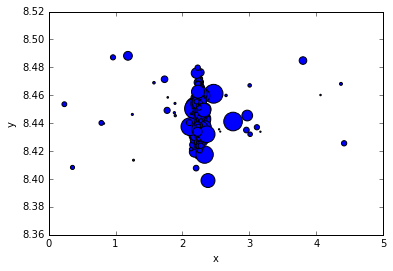

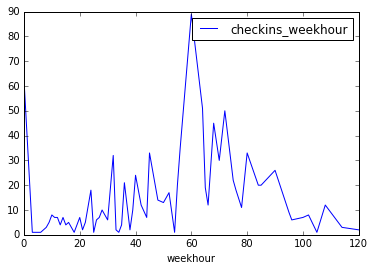

In [60]:
place_id = places[places.checkins > 100].sample(1)['place_id'].values[0]
place = byplace.get_group(place_id)
place.plot.scatter(x='x', y='y', s=(place.accuracy * 400)/place.accuracy.max())
place_hour = places_hour[places_hour.place_id == place_id]
place_hour.plot(x='weekhour', y='checkins_weekhour')

In [12]:
places_hour.to_csv('models/places_hour.csv', index=False)

In [62]:
def split_checkins(checkins, n_folds_x=4, n_folds_y=4, interval_x=10., interval_y=10.):
    
    size_x = interval_x / n_folds_x
    size_y = interval_y / n_folds_y
    
    checkin_split = []
    
    for j in range(n_folds_y):
        for i in range(n_folds_x):
            
            if i == 0:
                #str_x = '< {0}'.format((i+1)*size_x) 
                bool_x = checkins.x < (i+1)*size_x
            elif i == n_folds_x - 1:
                #str_x = '>= {0}'.format(i*size_x) 
                bool_x = checkins.x >= i*size_x
            else:
                #str_x = '>= {0}, < {1}'.format(i*size_x, (i+1)*size_x)
                bool_x = (checkins.x >= i*size_x) & (checkins.x < (i+1)*size_x)
                
            if j == 0:
                #str_y = '< {0}'.format((j+1)*size_y) 
                bool_y = checkins.y < (j+1)*size_y
            elif j == n_folds_y - 1:
                #str_y = '>= {0}'.format(j*size_y)
                bool_y = checkins.y >= j*size_y
            else:
                #str_y = '>= {0}, < {1}'.format(j*size_y, (j+1)*size_y) 
                bool_y = (checkins.y >= j*size_y) & (checkins.y < (j+1)*size_y)
            
            #print(i, j, str_x, str_y)
            split = checkins[bool_x & bool_y]
            split.reset_index(inplace=True, drop=True)
            checkin_split.append(split)
    
    return checkin_split

In [63]:
train_list = split_checkins(train)
#test_list = split_checkins(test)

In [9]:
def save_split_data(data, name):
    for i, checkins in enumerate(data):
        checkins.to_csv('data/{0}_{1}.csv'.format(name, i), index=False)

In [29]:
save_split_data(train_list, 'train')
#save_split_data(test_list, 'test')

In [30]:
test_list[1].head()

,row_id,x,y,accuracy,time,weekhour,day
0,19,2.7856,1.7072,61,884954,13,7
1,20,3.6321,2.2853,67,905857,2,22
2,62,2.7966,0.0302,68,856864,3,19
3,112,2.9562,0.5535,72,879795,92,3
4,152,3.2196,1.6380,21,790789,18,4


# Retrieve candidate places

In [9]:
places = pandas.read_csv('models/places.csv')
places_checkins = places['checkins'].values
#places['place_index'] = places.index

In [10]:
# excluding venues with less than X checkins
#place_tree = KDTree(places[places.checkins > 90][['x', 'y']])
place_tree = KDTree(places[['x', 'y']])

array([ 75,  95, 555, ...,  59, 495, 214])

In [11]:
metric = DistanceMetric.get_metric('minkowski')
def distance(a):
    points = [[a[0], a[1]], [a[2], a[3]]]
    return metric.pairwise(points)[0][1]

places['place_index'] = places.index

def get_nearest_neighbors(checkins, n_neighbors = 100):    
    
    distances, nearest = place_tree.query(checkins[['x','y']], k=n_neighbors)
    return (distances, nearest)

def get_most_popular(distances, nearest, n_popular = 20):
    
    new_nearest = []
    new_distances = []
    
    for i, neighbors in enumerate(nearest):
        popular_indexes = places_checkins[neighbors].argsort()[-1*n_popular:][::-1]
        new_distances.append(distances[i][popular_indexes])
        new_nearest.append(neighbors[popular_indexes])
    
    return (new_distances, new_nearest)
    
def save_popular_neighbors(data, name, n_popular=20, n_nearest=100):

    for i in range(1):
    #for i, checkins in enumerate(data):
        #checkins = data[i]
        print('Loading trainng data...')
        checkins = pandas.read_csv('data/{0}_{1}.csv'.format(name, i))
        
        distances, nearest = get_nearest_neighbors(checkins, n_nearest)
        distances, nearest = get_most_popular(distances, nearest, n_popular)
        
        #print(nearest)
        
        if 'place_id' in checkins.columns:
            checkin_place = pandas.merge(checkins, places[['place_id', 'x', 'y', 'place_index']], on='place_id')
            checkin_place['distance'] = checkin_place[['x_x', 'y_x', 'x_y', 'y_y']].apply(distance, axis = 1)

            place_indexes = checkin_place['place_index'].values
            distances_places = checkin_place['distance'].values

            # always include ground truth among candidate places
            nearest = numpy.append(nearest, numpy.reshape(place_indexes, (-1, 1)), axis=1)
            distances = numpy.append(distances, numpy.reshape(distances_places, (-1, 1)), axis=1)

        numpy.save('data/neareast_{0}_{1}_{2}'.format(n_popular, name, i), nearest)
        numpy.save('data/distances_{0}_{1}_{2}'.format(n_popular, name, i), distances)

In [ ]:
save_popular_neighbors(None, 'train')
#save_popular_neighbors(test_list, 'test')

Loading trainng data...


In [44]:
places[places.checkins < 80].shape

(17206, 7)

In [ ]:
# This cell fixes existing nearest/distances files without ground truth place data

'''metric = DistanceMetric.get_metric('minkowski')
def distance(a):
    points = [[a[0], a[1]], [a[2], a[3]]]
    return metric.pairwise(points)[0][1]

for i in range(16):
    
    print(i)
    
    checkins = pandas.read_csv('data/train_{0}.csv'.format(i))
    
    print('Merging...')
    checkin_place = pandas.merge(checkins, places[['place_id', 'x', 'y', 'place_index']], on='place_id')
    checkin_place['distance'] = checkin_place[['x_x', 'y_x', 'x_y', 'y_y']].apply(distance, axis = 1)
    
    place_indexes = checkin_place['place_index'].values
    distances_places = checkin_place['distance'].values
    
    print('Loading nearest files...')
    
    nearest = numpy.load('data/neareast{0}_{1}.npy'.format(n_neighbors, i))
    distances = numpy.load('data/distances{0}_{1}.npy'.format(n_neighbors, i))
    
    print('Appending...')
    
    nearest = numpy.append(nearest, numpy.reshape(place_indexes, (-1, 1)), axis=1)
    distances = numpy.append(distances, numpy.reshape(distances_places, (-1, 1)), axis=1)
    
    print('Saving...')
    
    numpy.save('data/neareast{0}_{1}'.format(n_neighbors, i), nearest)
    numpy.save('data/distances{0}_{1}'.format(n_neighbors, i), distances)'''